In [1]:
import torch
from torchopt import adamw
from tqdm.auto import tqdm
from optree import tree_map, tree_map_
import pickle
import matplotlib.pyplot as plt
import numpy as np

import uqlib

from load import load_dataloaders, load_model

In [2]:
# Load data
train_dataloader, eval_dataloader = load_dataloaders(small=True, batch_size=32)
num_data = len(train_dataloader.dataset)
print("Training data size: ", num_data)

Training data size:  1000


In [3]:
# Load model (with standard Gaussian prior)
model, param_to_log_posterior = load_model(num_data=num_data, prior_sd=1e3)

# Turn off Dropout
model.eval()

# Load to GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device);

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Only train the last layer
for name, param in model.named_parameters():
    if 'bert' in name:
        param.requires_grad = False

# Extract only the parameters to be trained
sub_params, sub_param_to_log_posterior = uqlib.extract_requires_grad_and_func(dict(model.named_parameters()), param_to_log_posterior)

In [5]:
# Store initial values of sub_params to check against later
init_sub_params = tree_map(lambda x: x.detach().clone(), sub_params)

In [6]:
# Initiate variational parameters
init_mean = sub_params
init_log_sds = tree_map(
    lambda x: (torch.zeros_like(x, requires_grad=True) - 2.0), init_mean
)

In [7]:
# Optimization setup
num_epochs = 30
num_training_steps = num_epochs * len(train_dataloader)

optimizer = adamw(lr=5e-3)
# optimizer = adamw(lr=lambda i: 1e-1 * (1 - i / num_training_steps))

In [8]:
# Optimize
vi_transform = uqlib.vi.diag.build(
    sub_param_to_log_posterior, optimizer, init_log_sds=init_log_sds,
    temperature=1/num_data, n_samples=1, stl=False)
vi_state = vi_transform.init(init_mean)

progress_bar = tqdm(range(num_training_steps))

nelbos = []

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        vi_state = vi_transform.update(vi_state, batch)
        print(vi_state.nelbo, end="\r")
        nelbos.append(vi_state.nelbo)
        progress_bar.update(1)

  0%|          | 0/960 [00:00<?, ?it/s]

In [9]:
def plot_moving_average(data, window):
    moving_average = np.convolve(data, np.ones(window)/window, mode='valid')
    plt.plot(data, label='Original Data')
    plt.plot(range(window - 1, len(data)), moving_average, label='Moving Average', color='orange')
    plt.legend()

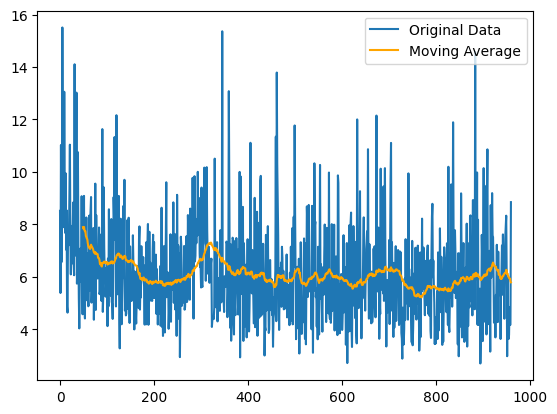

In [10]:
# Plot moving average of nelbo
plot_moving_average(nelbos, 50)

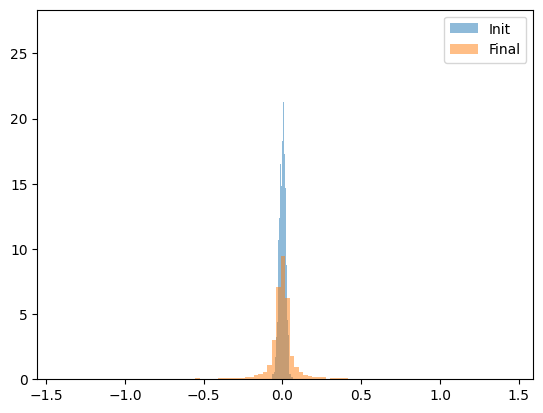

In [11]:
# Visualize trained sub_params vs their initial values
final_sub_params = tree_map(lambda p: p.detach().clone(), dict(model.named_parameters()))

init_untrained_params = torch.cat([v.flatten() for k, v in init_sub_params.items() if 'bert' not in k])
final_untrained_params = torch.cat([v.flatten() for k, v in final_sub_params.items() if 'bert' not in k])

plt.hist(init_untrained_params.cpu().numpy(), bins=100, alpha=0.5, label='Init', density=True)
plt.hist(final_untrained_params.cpu().numpy(), bins=100, alpha=0.5, label='Final', density=True)
plt.legend();

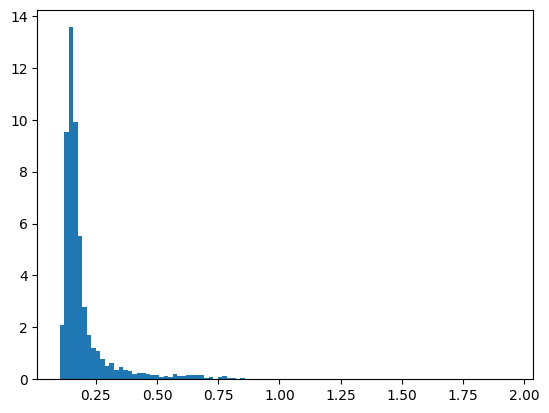

In [12]:
# Visualize the standard deviations of the final Normal distribution
sd_diag = torch.cat([v.exp().detach().cpu().flatten() for v in vi_state.log_sd_diag.values()]).numpy()

plt.hist(sd_diag, bins=100, density=True);

In [13]:
# Save state
def detach_cpu(x):
    if isinstance(x, torch.Tensor):
        x.detach().cpu()

vi_state = tree_map_(detach_cpu, vi_state)
pickle.dump(vi_state, open("yelp_vi_state.pkl", "wb"))

In [14]:
# # Alternative implementation that updates mu and log_sigma directly without using the
# # uqlib transform API

# from torch.optim import AdamW
# from transformers import get_scheduler


# mu = dict(model.named_parameters())
# log_sigma = tree_map(lambda x: torch.zeros_like(x, requires_grad=True), mu)

# vi_params_tensors = list(mu.values()) + list(log_sigma.values())

# vi_optimizer = AdamW(vi_params_tensors, lr=5e-5)
# vi_lr_scheduler = get_scheduler(
#     name="linear",
#     optimizer=vi_optimizer,
#     num_warmup_steps=0,
#     num_training_steps=num_training_steps,
# )

# progress_bar = tqdm(range(num_training_steps))

# nelbos = []

# # model.train()
# for epoch in range(num_epochs):
#     for batch in train_dataloader:
#         batch = {k: v.to(device) for k, v in batch.items()}
#         vi_optimizer.zero_grad()

#         sigma = tree_map(torch.exp, log_sigma)

#         nelbo, _ = uqlib.vi.diag.nelbo(
#             mu,
#             sigma,
#             batch,
#             param_to_log_posterior,
#         )

#         nelbo.backward()
#         nelbos.append(nelbo.item())

#         vi_optimizer.step()
#         vi_lr_scheduler.step()
#         progress_bar.update(1)